<a href="https://colab.research.google.com/github/Faizan-Rashid/deep-learning-pytorch/blob/main/02_pytorch_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network Classification with pytorch

Classification is a problem of prediction whether something is one thing or another.

## 1. Make Classification data and get it ready


In [ ]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(
    n_samples,
    noise=0.03,
    random_state=42
)

print(f"X : \n {X[:5]}")
print(f"y : \n {y[:5]}")


X : 
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
y : 
 [1 1 1 1 0]


In [ ]:
import pandas as pd
circles = pd.DataFrame(
    {
        "X1":X[:, 0],
        "X2":X[:, 1],
        "label":y
    }
)

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [ ]:
circles.label.value_counts()

,count
label,
1,500
0,500


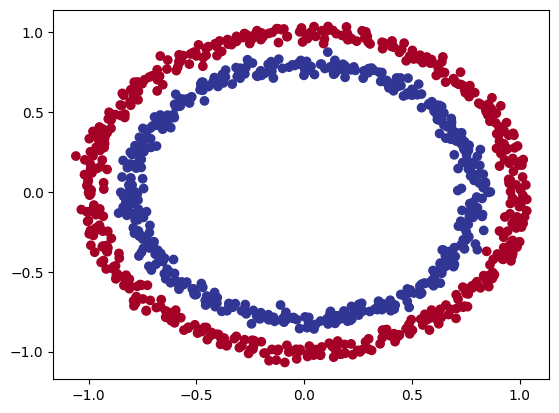

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(
    x=X[:, 0],
    y=X[:, 1],
    c=y,
    cmap=plt.cm.RdYlBu
)

### 1.1 Check input and output shapes

In [ ]:
X.shape, y.shape

((1000, 2), (1000,))

In [ ]:
# first example of features and labels

x_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of x {x_sample} and same for y {y_sample}")
print(f"Shape for one sample of x {x_sample.shape} and same for y {y_sample.shape}")

Values for one sample of x [0.75424625 0.23148074] and same for y 1
Shape for one sample of x (2,) and same for y ()


### 1.2 Turn data into train and test splits

In [ ]:
import torch

torch.__version__

'2.9.0+cpu'

In [ ]:
type(X)

numpy.ndarray

In [ ]:
# turn into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

In [ ]:
len(X_train),  len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building the model

we will build a model to classify our blue and red dots.

we'll follow these steps
1. set up device agnostoc code so our code will run on accelerator (GPU) if there is oe
2. construct a mode (by subclassing nn.Module)
3. Define a loss function and optimizer
4. training and testing loop

In [ ]:
import torch
from torch import nn

# Make device agnostoc code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Now we've set up agnostic code for device we'll create a model
steps:

1. Subclass `nn.Module` (as all pytorch model subclass nn.Module)
2. create 2 `nn.Linear()` layers that are capable for handling the shapes of our data
3. define `forward()` method that outlines the forward pass of forward computation of our model
4. Instantiate our model class and send it to target device

In [ ]:
# 1.creating the model

class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. creating layers that are capable of handling the shapes of our data
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in two features and upsacales it to 5 fetaures
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features from previous layer and outputs single feature (same shape as y)

  # 3. define the forward method
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output

# Instatntiate model class and send it to target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
device

'cpu'

In [ ]:
next(model_0.parameters()).device

device(type='cpu')

nn.sequential is just another simple short way to create the model

In [ ]:
# let's replicate the model above by using nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1),
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.5869,  0.0542],
                      [ 0.6873,  0.0767],
                      [ 0.2356, -0.5798],
                      [-0.1555, -0.1526],
                      [ 0.1475, -0.2082]])),
             ('0.bias', tensor([ 0.5608,  0.1564,  0.2299, -0.3065,  0.4393])),
             ('1.weight',
              tensor([[ 0.4342, -0.0778,  0.4208, -0.3253,  0.4182]])),
             ('1.bias', tensor([-0.1997]))])

In [ ]:
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))

In [ ]:
print(f"length of untrained predictions : {len(untrained_preds)}, shape : {untrained_preds.shape}")
print(f"length of test data : {len(X_test)}, shape : {X_test.shape}")
print(f"first 10 test samples: {X_test[:10]}")
print(f"first 10 predictions: {untrained_preds[:10]}")
print(f"first 10 test labels: {y[:10]}")

length of untrained predictions : 200, shape : torch.Size([200, 1])
length of test data : 200, shape : torch.Size([200, 2])
first 10 test samples: tensor([[-0.3752,  0.6827],
        [ 0.0154,  0.9600],
        [-0.7028, -0.3147],
        [-0.2853,  0.9664],
        [ 0.4024, -0.7438],
        [ 0.6323, -0.5711],
        [ 0.8561,  0.5499],
        [ 1.0034,  0.1903],
        [-0.7489, -0.2951],
        [ 0.0538,  0.9739]])
first 10 predictions: tensor([[0.2680],
        [0.1570],
        [0.5629],
        [0.1844],
        [0.5690],
        [0.5012],
        [0.1837],
        [0.2644],
        [0.5622],
        [0.1496]])
first 10 test labels: tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.])


### 2.1 setup loss function and optimizer

this is problem specific

e.g in linear regression , you might want MAE or MSE

For classification, you might want binary cross entropy or categorical cross entropy

Reminder -- loss function measure how *wrong* your model's predictions are

optimizers - two most useful are SGD and Adam , however pytorch has lots of build in options.

Article to learn more about Binary-cross Entropy

https://medium.com/data-science/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a

In [ ]:
# set up loss function and optimizer
# loss_fn = nn.BCELoss # requires input to have gone through sigmoid activation function

# loss function
loss_fn = nn.BCEWithLogitsLoss() # built-in sigmoid activation function

# optimizer
optimizer = torch.optim.SGD(
    params=model_0.parameters(),
    lr=0.1
)

In [ ]:
# Calculate accuracy - out of 100, what percentage our model gets right
def accuracy(y_true, y_preds):
  correct = torch.eq(y_true, y_preds).sum().item()
  accuracy =  (correct / len(y_true)) * 100
  return accuracy

## 3. Training

Do the following steps for training:
1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. loss backward (Backpropogation)
5. Optimizer step

### 3.1 Going from raw logits -> prdiction probabilities -> prediction labels

Our model's output are going to be raw referred as **logits** and they are not passed to any activation function yet.

check here for more about logits:
https://datascience.stackexchange.com/questions/31041/what-does-logits-in-machine-learning-mean/31045#31045

We can convert these **logits** innto **predciction probabilities** by usine some kind of activation function (e.g sigmoid for binary classification and softmax for multi-class classification)

Then we can convert to our model's **prdiction probabilites** into **prdiction labels** by `rounding` then (for binary classification) or by `argmax()` (for output of softmax activation function)

**Reminder -- When we pass the our data through the linear layer (torch.Linear), it actually applies the Linear transformation on incoming data given as
$$ \mathbf{y} = x \cdot \mathbf{Weights}^T + \mathbf{bias} $$**

In [ ]:
# View the first 5 logits of our model's output
model_0.eval() # turn model into evaluation mode for better predictions
with torch.inference_mode():
  y_logits = model_0(X_test.to(device)[:5])
y_logits

tensor([[0.2680],
        [0.1570],
        [0.5629],
        [0.1844],
        [0.5690]])

In [ ]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [ ]:
# use the sigoid function in torch to turnn our logits into prdiction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5666],
        [0.5392],
        [0.6371],
        [0.5460],
        [0.6385]])

we need a range style rounding

* `y_pred_probs` >= 0.5 y = 1 (class 1)
* `y_pred_probs` < 0.5  y = 0 (class 0)

In [ ]:
y_preds = torch.round(y_pred_probs)

# just done all in one step (logits -> predction probabilities -> prediction labels)
model_0.eval()
with torch.inference_mode():
  y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device)[:5])))

# check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze(), y_pred_labels.squeeze()

tensor([True, True, True, True, True])


(tensor([1., 1., 1., 1., 1.]), tensor([1., 1., 1., 1., 1.]))

### 3.2 Building a Training and Testing loop

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# put data to target device
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)


epochs = 100

for epoch in range(epochs):
  ### Training
  model_0.train()

  ## 1. do the forward pass
  y_logits = model_0(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))

  ## 2. calculate the loss and accuracy
  # loss = loss_fn(torch.sigmoid(y_logits), y_train) # nn.BCELoss expects prediction probabilities to be inputs
  loss = loss_fn(y_logits, y_train) # because BCELossWithLogits expects raw logits to be inputs
  acc = accuracy(
      y_true=y_train,
      y_preds=y_preds
  )

  ## 3. zero the accumulated gradient
  optimizer.zero_grad()

  ## 4. perform the backward pass (backpropgation) - gradient of calculated loss with respect to each parameter
  loss.backward()

  ## 5. optimizer zero step (gradient step) - optimiser uses grads to check how much each parameter be updated and updates them
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    ## 1. forward pass
    y_test_logits = model_0(X_test).squeeze()
    y_test_preds = torch.round(torch.sigmoid(y_test_logits))

  ## 2. calculate the loss
  test_loss = loss_fn(y_test_logits, y_test)
  test_acc = accuracy(y_true=y_test, y_preds=y_test_preds)

  if(epoch % 10 == 0):
    print(f"epoch : {epoch} | loss : {loss: .5f} | Accuracy : {acc:.2f}% | test loss : {test_loss:.5f} test accuracy : {test_acc:.2f}%")
  # print(f"loss for epoch {epoch} is : {test_loss}")
  # print(f"correct labels : {y_test[:10]} --- predictions {y_test_preds.squeeze()[:10]}")
  # print(f"comparison {torch.eq(y_test_preds, y_test)}")




epoch : 0 | loss :  0.72012 | Accuracy : 50.00% | test loss : 0.70769 test accuracy : 50.00%
epoch : 10 | loss :  0.70416 | Accuracy : 54.37% | test loss : 0.69568 test accuracy : 57.00%
epoch : 20 | loss :  0.69882 | Accuracy : 53.75% | test loss : 0.69215 test accuracy : 53.50%
epoch : 30 | loss :  0.69673 | Accuracy : 51.50% | test loss : 0.69112 test accuracy : 53.50%
epoch : 40 | loss :  0.69576 | Accuracy : 50.50% | test loss : 0.69089 test accuracy : 54.00%
epoch : 50 | loss :  0.69521 | Accuracy : 49.38% | test loss : 0.69091 test accuracy : 54.50%
epoch : 60 | loss :  0.69485 | Accuracy : 49.00% | test loss : 0.69102 test accuracy : 54.50%
epoch : 70 | loss :  0.69457 | Accuracy : 49.00% | test loss : 0.69115 test accuracy : 54.50%
epoch : 80 | loss :  0.69435 | Accuracy : 49.00% | test loss : 0.69130 test accuracy : 54.00%
epoch : 90 | loss :  0.69416 | Accuracy : 49.12% | test loss : 0.69145 test accuracy : 53.50%


## 4. Make predictions and evaluate our model

From the metrics, it looks like our model isn't learning anything. The ideal accuraccy would be 100 and ideal loss be 0.

we'll try to visualize it

In [ ]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("file exists")
else:
  print("downloading helper_functions.py")
  res = requests.get("https://raw.githubusercontent.com/Faizan-Rashid/deep-learning-pytorch/refs/heads/main/helper_functions.py")
  print(res.content)

  with open("helper_functions.py", "wb") as f:
    f.write(res.content)

from helper_functions import plot_predictions, plot_decision_boundary

downloading helper_functions.py
b'"""\nA series of helper functions used throughout the course.\n\nIf a function gets defined once and could be used over and over, it\'ll go in here.\n"""\nimport torch\nimport matplotlib.pyplot as plt\nimport numpy as np\n\nfrom torch import nn\n\nimport os\nimport zipfile\n\nfrom pathlib import Path\n\nimport requests\n\n# Walk through an image classification directory and find out how many files (images)\n# are in each subdirectory.\nimport os\n\ndef walk_through_dir(dir_path):\n    """\n    Walks through dir_path returning its contents.\n    Args:\n    dir_path (str): target directory\n\n    Returns:\n    A print out of:\n      number of subdiretories in dir_path\n      number of images (files) in each subdirectory\n      name of each subdirectory\n    """\n    for dirpath, dirnames, filenames in os.walk(dir_path):\n        print(f"There are {len(dirnames)} directories and {len(filenames)} images in \'{dirpath}\'.")\n\ndef plot_decision_boundary(mod

Text(0.5, 1.0, 'Test')

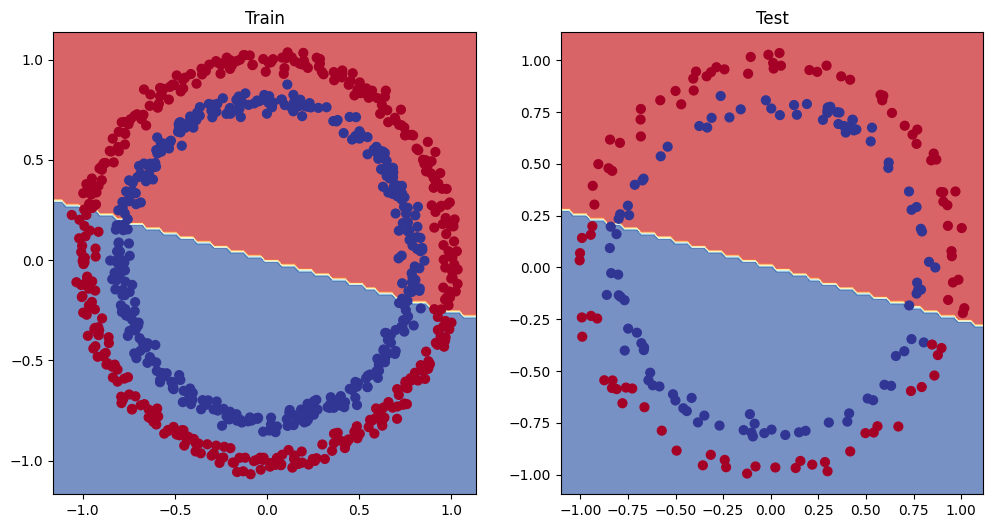

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2 ,1)
plot_decision_boundary(model_0, X_train, y_train)
plt.title("Train")
plt.subplot(1, 2 ,2)
plot_decision_boundary(model_0, X_test, y_test)
plt.title("Test")


## 5. Improving our model

* Add more layers - give the model more chances to learn from data
* Add more hidden units - go from 5 units to may be 10
* changing the activation funnction
* changing the loss function
* changing the learning rate
* Fit for longer - increase number of epochs

These options are from the model's perspective as they directly deal with the model rather than data.

And as these values can be changed by us as ML engineer so they are referred as **hyperparameters**.

Here is how we'll improve our model:
1. increase layers 2->3
2. Adding more hidden units 5->10
3. epochs increase 100->1000


In [ ]:
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [ ]:
# create the model
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1  = nn.Linear(2, 10)
    self.layer2  = nn.Linear(10, 10)
    self.layer3  = nn.Linear(10, 1)

  def forward(self, x):
    return self.layer3(self.layer2(self.layer1(x)))

# instantiate and move to the target device
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
model_1.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]])),
             ('layer1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984])),
             ('layer2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, -0.2426,  0.2595,  0.0911,  0.1310

In [ ]:
# loss function
loss_fn = nn.BCEWithLogitsLoss()
# optimizer
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [ ]:
torch.manual_seed(42)

epochs = 1000 # Train for longer

# Put data to the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ### Training
  model_1.train()
  # Forward pass
  y_logits = model_1(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))
  acc = accuracy(y_train, y_preds)
  # calculate the loss
  loss = loss_fn(y_logits, y_train)
  # backward propogation
  loss.backward()
  # perform zero grad
  optimizer.zero_grad()
  # optimiser step
  optimizer.step()

  ### Testing
  # Forward pass
  y_test_logits = model_1(X_test).squeeze()
  y_test_preds = torch.round(torch.sigmoid(y_test_logits))
  test_acc = accuracy(y_test, y_test_preds)
  # calculate loss
  test_loss = loss_fn(y_test_logits, y_test)
  if (epoch % 100 == 0):
    print(f"epoch : {epoch}")
    print(f"training accuracy : {acc} \ntrain loss : {loss}")
    print(f"test accuracy : {test_acc} \ntest loss : {test_loss}")


epoch : 0
training accuracy : 50.875 
train loss : 0.6939550638198853
test accuracy : 51.0 
test loss : 0.6926102638244629
epoch : 100
training accuracy : 50.875 
train loss : 0.6939550638198853
test accuracy : 51.0 
test loss : 0.6926102638244629
epoch : 200
training accuracy : 50.875 
train loss : 0.6939550638198853
test accuracy : 51.0 
test loss : 0.6926102638244629
epoch : 300
training accuracy : 50.875 
train loss : 0.6939550638198853
test accuracy : 51.0 
test loss : 0.6926102638244629
epoch : 400
training accuracy : 50.875 
train loss : 0.6939550638198853
test accuracy : 51.0 
test loss : 0.6926102638244629
epoch : 500
training accuracy : 50.875 
train loss : 0.6939550638198853
test accuracy : 51.0 
test loss : 0.6926102638244629
epoch : 600
training accuracy : 50.875 
train loss : 0.6939550638198853
test accuracy : 51.0 
test loss : 0.6926102638244629
epoch : 700
training accuracy : 50.875 
train loss : 0.6939550638198853
test accuracy : 51.0 
test loss : 0.6926102638244629
ep

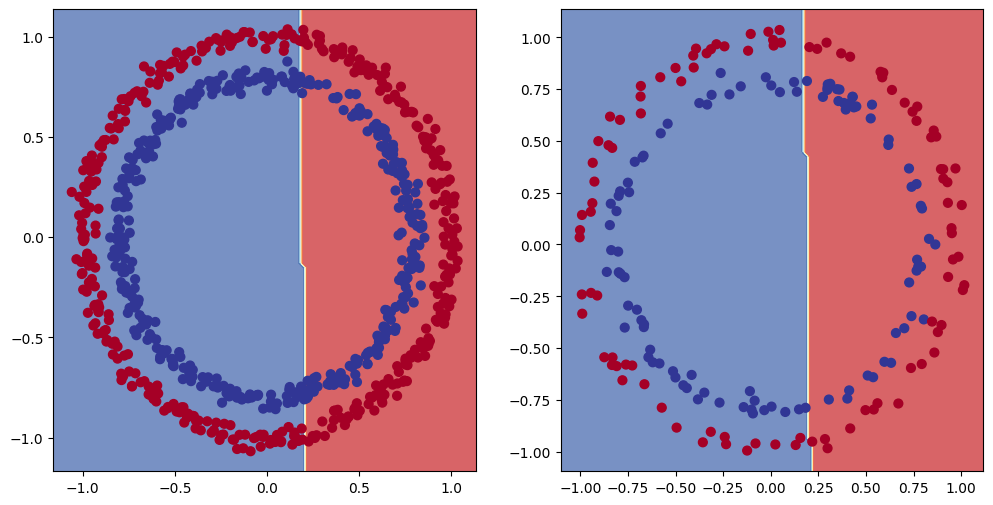

In [ ]:
from helper_functions import plot_decision_boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a straight line


In [ ]:
import numpy as np
start = 0.0
end = 1.0
step = 0.01

weight = 0.7
bias = 0.3

X = torch.arange(start, end , step).unsqueeze(dim=1)
X.shape

torch.Size([100, 1])

In [ ]:
y = X * weight + bias
y.shape

torch.Size([100, 1])

In [ ]:
# splitting the data into train and test splits
train_size = int(len(X) / 100 * 80)
# test_size = len(X) / 100 * 20

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"""X_train length : {len(X_train)}, X_test length : {len(X_test)}
y_train length : {len(y_train)}, y_test length : {len(y_train)}""")

X_train length : 80, X_test length : 20
y_train length : 80, y_test length : 80


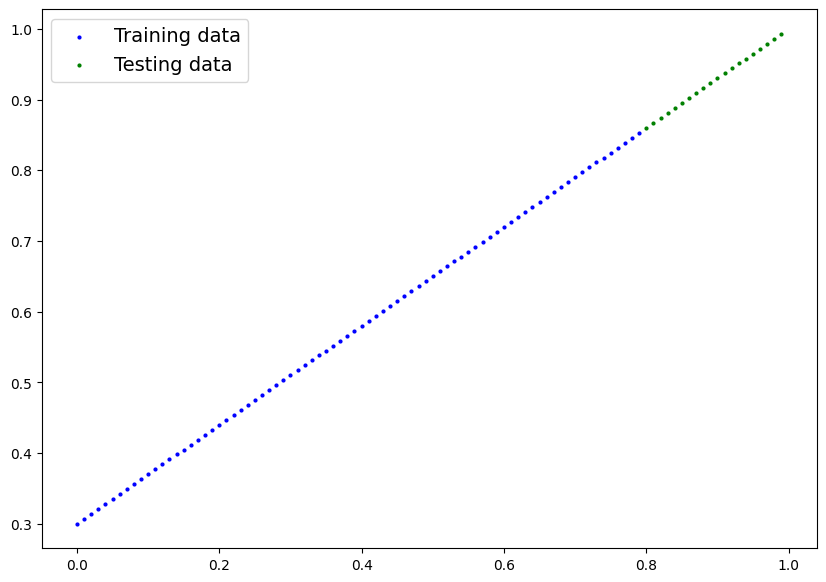

In [ ]:
# plot labels and features
from helper_functions import plot_predictions
plot_predictions(X_train, y_train, X_test, y_test)

### 5.2 Adjusting the model_1 to fit the straight line

In [ ]:
from torch import nn
model_2 = nn.Sequential(
    nn.Linear(1, 10),
    nn.Linear(10, 10),
    nn.Linear(10, 1)
).to(device)
model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

plotting the predictions before trainiing the model

In [ ]:
model_2.eval()
with torch.inference_mode():
  y_preds = model_2(X_test)

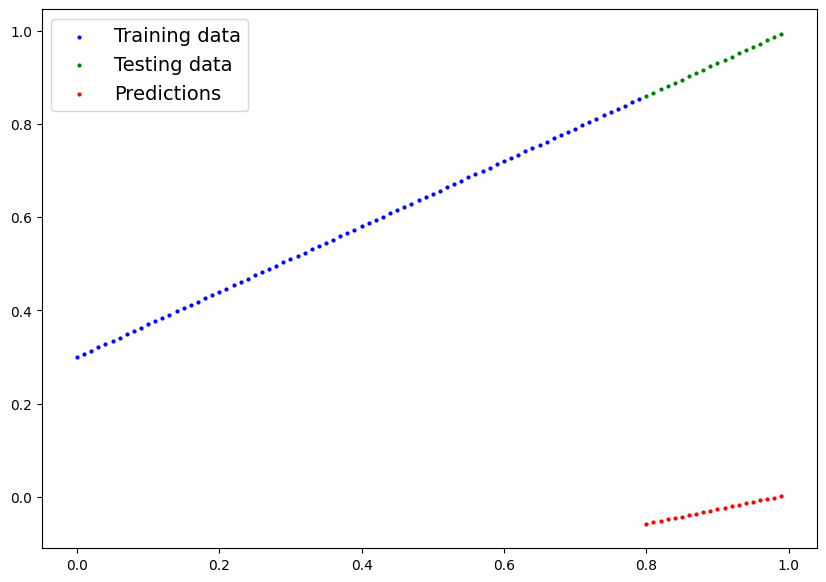

In [ ]:
plot_predictions(X_train, y_train, X_test, y_test, y_preds)

In [ ]:
# loss function and optimizer
loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.01)

In [ ]:
# training the model on linear data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
  ### Training
  # set the model to training mode
  # model_2.train()
  # 1. forward pass
  y_pred = model_2(X_train)
  # 2. calulate the loss
  loss = loss_fn(y_pred, y_train)
  # 3. zero grad
  optimizer.zero_grad()
  # 4. back prop
  loss.backward()
  # 5. optimizer step
  optimizer.step()

  ### testing
  model_2.eval()
  with torch.inference_mode():
    # 1. Forward pass
    y_test_preds = model_2(X_test)
    # 2. calculate the loss
    test_loss = loss_fn(y_test_preds, y_test)

    if(epoch % 100 == 0):
      print(f"""epoch : {epoch}
      loss : {loss : .5f}
      Test loss : {loss: .5f}""")


epoch : 0
      loss :  0.75986
      Test loss :  0.75986
epoch : 100
      loss :  0.02858
      Test loss :  0.02858
epoch : 200
      loss :  0.02533
      Test loss :  0.02533
epoch : 300
      loss :  0.02137
      Test loss :  0.02137
epoch : 400
      loss :  0.01964
      Test loss :  0.01964
epoch : 500
      loss :  0.01940
      Test loss :  0.01940
epoch : 600
      loss :  0.01903
      Test loss :  0.01903
epoch : 700
      loss :  0.01878
      Test loss :  0.01878
epoch : 800
      loss :  0.01840
      Test loss :  0.01840
epoch : 900
      loss :  0.01798
      Test loss :  0.01798


In [ ]:
model_2.eval()
with torch.inference_mode():
  y_preds = model_2(X_test)

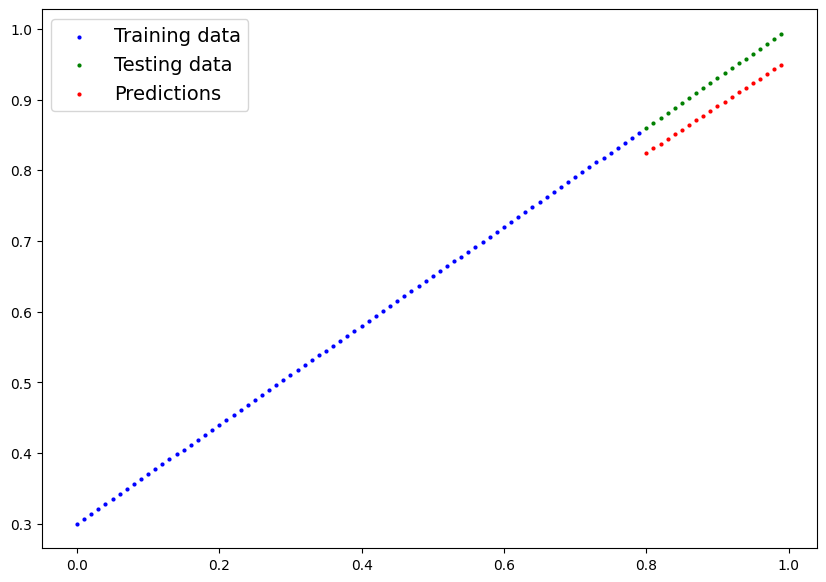

In [ ]:
plot_predictions(X_train, y_train, X_test, y_test, y_preds)

## 6. The missing - non-linearity

We've seen our model can draw straight (linear) lines, thanks to its linear layers.

But how about we give it the capacity to draw non-straight (non-linear) lines?

How?

Let's find out.

### 6.1 Recreating the non-linear data

In [ ]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
             noise=0.01,
             random_state=42)

X.shape, y.shape

((1000, 2), (1000,))

In [ ]:
# representing data as dataframe
import pandas as pd
data = pd.DataFrame({
    "X1":X[:,0],
    "X2":X[:,1],
    "y":y

})

data.head()

,X1,X2,y
0,0.766286,0.216276,1
1,-0.778285,0.137826,1
2,-0.800925,0.124605,1
3,-0.358326,0.713535,1
4,0.438813,-0.898511,0


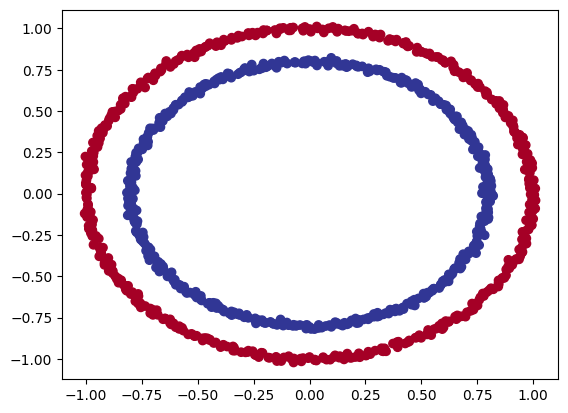

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(
    x=X[:,0],
    y=X[:,1],
    c=y,
    cmap=plt.cm.RdYlBu
)

In [ ]:
from sklearn.model_selection import train_test_split

# turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

### 6.2 Building a model with non-linearity

* linear = straight line
* non-linear = line not straight

Artificial neural networks are combination of linear (straight) and non-linear (non-straight) functions which are potentially able to find patterns in data

In [ ]:
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() # relu is non-linear activation function

  def forward(self, x):
    # where should we put our non-linear activation functions?
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)

model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
# loss function
loss_fn = torch.nn.BCEWithLogitsLoss()
# optmizer
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

### 6.3 Training the model with non-linearity

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
  ### Training
  model_3.train()
  # 1. Forward pass
  y_logits = model_3(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))
  acc = accuracy(y_true=y_train, y_preds=y_preds)
  # 2. calculate loss
  loss = loss_fn(y_logits, y_train)
  # 3. perform zero grad
  optimizer.zero_grad()
  # 4. backprop - gradient decent
  loss.backward()
  # 5. optimizer step - update paramaters
  optimizer.step()

  ### Testing
  model_3.eval()
  with torch.inference_mode():
    # 1. Forward pass
    y_test_logits = model_3(X_test).squeeze()
    y_test_preds = torch.round(torch.sigmoid(y_test_logits))
    test_acc = accuracy(y_true=y_test, y_preds=y_test_preds)
    # 2. calculate the loss
    loss = loss_fn(y_test_logits, y_test)

    if(epoch % 100 == 0):
      print(f"""epoch : {epoch}
            -------TRAINING INFO-------
            train loss : {loss}, training accuracy : {acc}
            -------TESTING INFO-------
            test loss : {test_loss}, testing accuracy : {test_acc}""")

epoch : 0
            -------TRAINING INFO-------
            train loss : 0.6952117681503296, training accuracy : 50.0
            -------TESTING INFO-------
            test loss : 0.03951023519039154, testing accuracy : 50.0
epoch : 100
            -------TRAINING INFO-------
            train loss : 0.6901443600654602, training accuracy : 50.125
            -------TESTING INFO-------
            test loss : 0.03951023519039154, testing accuracy : 55.00000000000001
epoch : 200
            -------TRAINING INFO-------
            train loss : 0.6870424151420593, training accuracy : 59.62499999999999
            -------TESTING INFO-------
            test loss : 0.03951023519039154, testing accuracy : 63.0
epoch : 300
            -------TRAINING INFO-------
            train loss : 0.6839770674705505, training accuracy : 60.0
            -------TESTING INFO-------
            test loss : 0.03951023519039154, testing accuracy : 62.0
epoch : 400
            -------TRAINING INFO-------
  

### 6.4 Evaluating the model trained with non-linear activation functions


In [ ]:
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

Text(0.5, 1.0, 'Test')

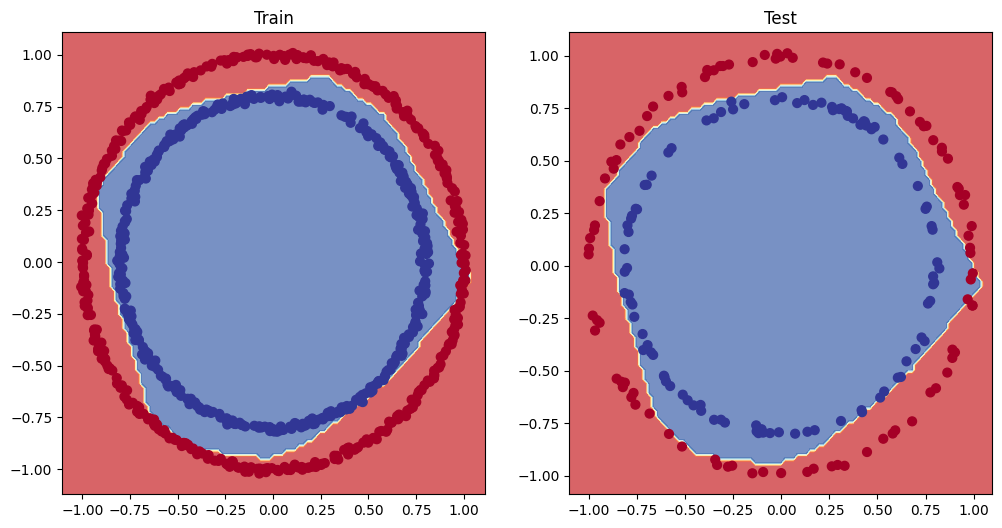

In [ ]:
# plot decision boundaries
from helper_functions import plot_decision_boundary
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plot_decision_boundary(model_3, X_train, y_train)
plt.title("Train")

plt.subplot(1, 2, 2)
plot_decision_boundary(model_3, X_test, y_test)
plt.title("Test")

**Challenge** Can you imporve the model to make better than 80% accuracy

## 7. Replicating the non-linear activation functions
neural networks rather than us telling the model what to learn, we give it tools to learn patterns in data.

ALl these tools are linear and non-linear functions.

In [ ]:
model_3.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.8114,  0.7747],
                      [ 0.3268,  1.4762],
                      [-0.0575,  0.2924],
                      [-0.7997,  0.6775],
                      [ 1.3229, -0.5248]])),
             ('layer_1.bias',
              tensor([ 1.1098, -0.2162,  0.7514, -0.0273,  0.1166])),
             ('layer_2.weight',
              tensor([[ 0.1301,  0.9499, -0.2056,  0.0016,  0.8228],
                      [-0.6229,  0.0087, -0.0535,  0.4953, -0.2359],
                      [-0.2062, -0.1263, -0.2689,  0.0422, -0.4417],
                      [ 0.7165, -0.7814,  0.5627, -0.1746, -0.5577],
                      [ 0.5595, -0.3186,  0.5674, -0.1968, -0.5115],
                      [-0.0586,  0.1321,  0.0785,  0.5591,  0.5693],
                      [-0.4053,  0.5893,  0.1880,  0.4730, -0.1184],
                      [-0.6527, -0.1142, -0.2385,  0.5420,  0.2190],
                      [ 0.4688,  0.5249, -0.0302,  0.5123, -0.1090],
  

In [ ]:
A = torch.arange(-10, 10, 1.0)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

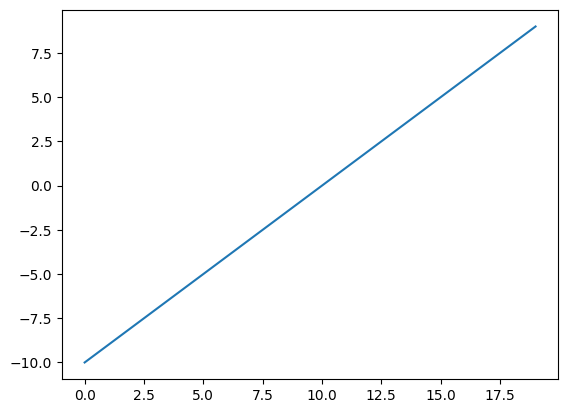

In [ ]:
plt.plot(A)

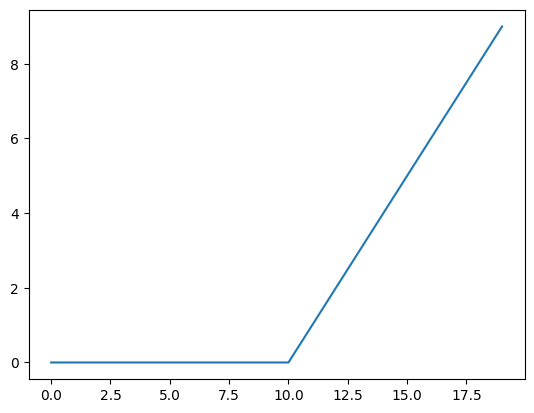

In [ ]:
plt.plot(torch.relu(A))

In [ ]:
# making our own relu function
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.max(torch.tensor(0), x)

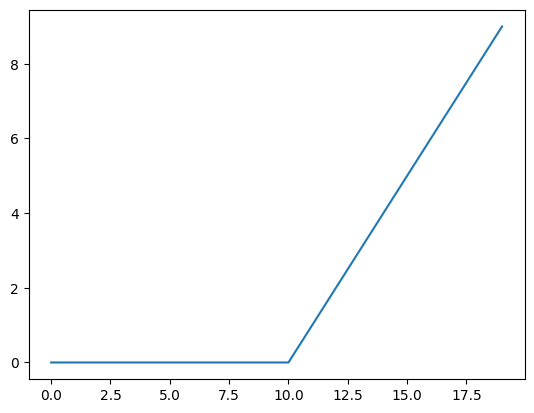

In [ ]:
plt.plot(relu(A))


In [ ]:
# let's do same for sigmoid (1 / 1 + epx(-x)) - https://docs.pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html
def sigmoid(x: torch.Tensor) -> torch.Tensor:
  return 1 / (1 + torch.exp(-x))

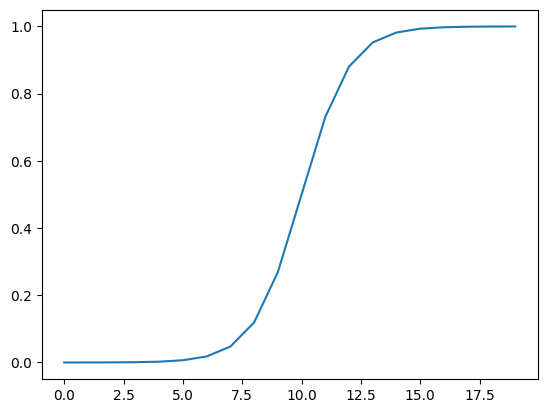

In [ ]:
plt.plot(torch.sigmoid(A))

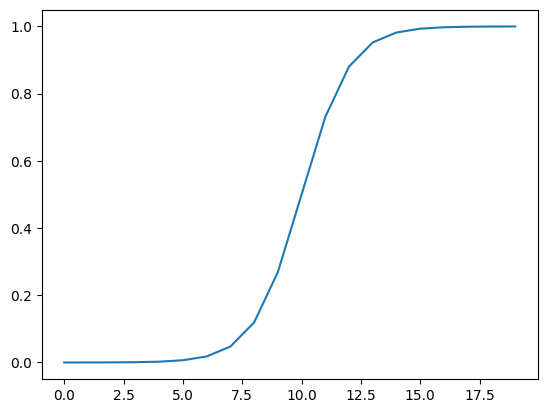

In [ ]:
plt.plot(sigmoid(A))

## 8. Putting it all together with a multi-class classification problem

* Binary classififcation - one thing or another
* Multi-class classification - more than one thing or another

### 8.1 Toy Multiclass dataset


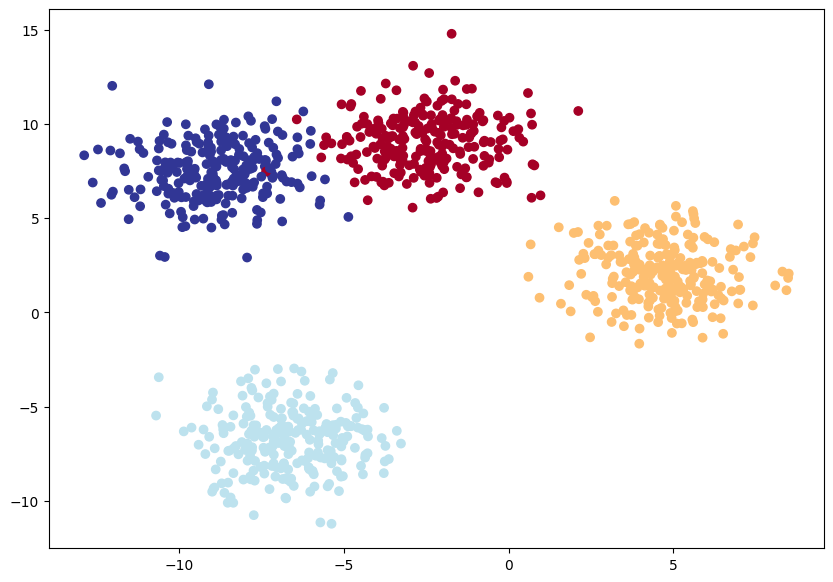

In [ ]:
# import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import numpy as np

# set hyper paramters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create the data
X_blob, y_blob = make_blobs(
    n_samples=1000,
    n_features=NUM_FEATURES,
    centers=NUM_CLASSES,
    random_state=RANDOM_SEED,
    cluster_std=1.5
)

# 2. Turn the data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split the data into train and test splits
X_train_blob, X_test_blob, y_train_blob, y_test_blob = train_test_split(X_blob,
                 y_blob,
                 test_size=0.2,
                 random_state=RANDOM_SEED)

# 4. Visualize the data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

### 8.2 Building a multi-class classification model

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
# Build multi-class classification model
# out current data is actually linearly separable as I commented the ReLU() and re-run the code with 99.5 accuracy
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """
    Initializes a multi-class classification model

    Args:
    1. in_features : Number of input features to the model
    2. out_features: Number of output features to the model (number of classes)
    3. hidden units: Number of hidden units between layers
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=NUM_FEATURES, out_features=hidden_units),
        # nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        # nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

model_4 = BlobModel(
      input_features=NUM_FEATURES,
      output_features=NUM_CLASSES,
      hidden_units=8
  )

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 Creating a loss-function and optimizer for a multi-class pytorch model

In [ ]:
# loss function
loss_fn = nn.CrossEntropyLoss()

# optimzer
optimzier = torch.optim.SGD(
    params=model_4.parameters(),
    lr=0.1
)

### 8.4 Getting prediction probabilities for a multi-class pytorch model

logits (raw model output) -> prediction probabilities (`torch.softmax()`) -> prediction labels (take the argmax of the prediction porobabilities)

In [ ]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_test_blob.to(device))

y_logits[:5]

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]])

In [ ]:
y_pred_probs = torch.softmax(
    input=y_logits,
    dim=1
)

y_pred_probs[:5]

tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]])

In [ ]:
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([3, 3, 2, 1, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2,
        2, 2, 3, 3, 3, 3, 3, 1, 1, 2, 1, 2, 1, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3,
        3, 3, 1, 3, 3, 1, 3, 2, 3, 1, 3, 2, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 3, 3, 2, 3, 3, 3, 3, 2, 3, 1, 3, 3, 2, 1, 1, 3, 2, 2, 3, 3, 3, 1, 2,
        2, 3, 3, 1, 2, 3, 3, 3, 2, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 1, 1, 3, 2, 2,
        2, 2, 3, 3, 3, 2, 2, 1, 3, 2, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3,
        2, 2, 2, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 2, 2, 3, 2, 2, 3, 3, 2, 2, 3, 3,
        1, 3, 2, 3, 3, 1, 2, 3])

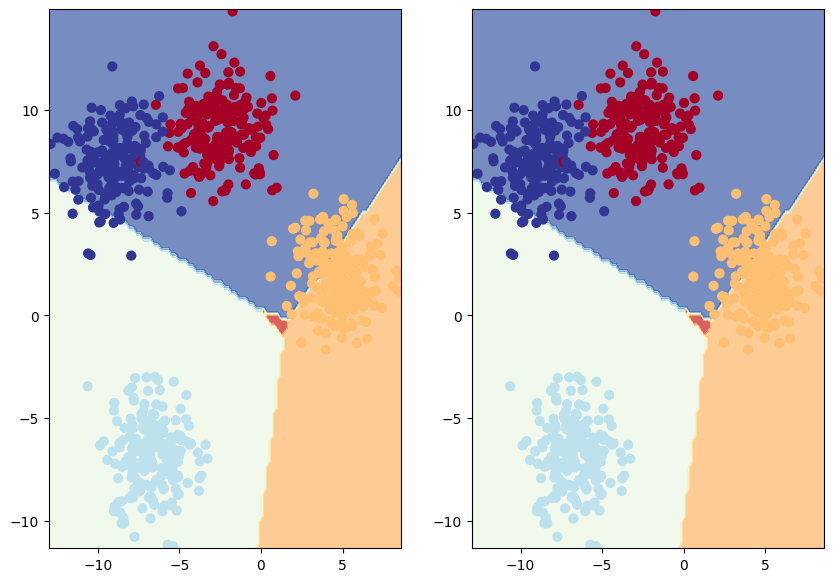

In [ ]:
import matplotlib.pyplot as plt
from helper_functions import plot_decision_boundary

plt.figure(figsize=(10, 7))

plt.subplot(1, 2, 1)
plot_decision_boundary(model_4, X_train_blob, y_train_blob)

plt.subplot(1, 2, 2)
plot_decision_boundary(model_4, X_train_blob, y_train_blob)

### 8.5 Training and testing multi-class pytorch model

In [ ]:
# set the random seed for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# put the data to the target device
X_train_blob, X_test_blob = X_train_blob.to(device), X_test_blob.to(device)
y_train_blob, y_test_blob = y_train_blob.to(device), y_test_blob.to(device)

# set the number of epochs
epochs = 100

for epoch in range(epochs):
  ### Training
  # 1. Forward pass
  model_4.train()
  y_logits = model_4(X_train_blob)
  y_pred = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
  acc = accuracy(
      y_true=y_train_blob,
      y_preds=y_pred
  )
  # 2. Loss
  loss = loss_fn(y_logits, y_train_blob)
  # 3. zero grad
  optimzier.zero_grad()
  # 4. backprop
  loss.backward()
  # 5. optimizer step
  optimzier.step()

  ### Testing
  model_4.eval()
  with torch.inference_mode():
    # 1. Forward pass
    y_test_logits = model_4(X_test_blob)
    y_test_preds = torch.argmax(torch.softmax(y_test_logits, dim=1), dim=1)
    test_acc = accuracy(
        y_true=y_test_blob,
        y_preds=y_test_preds
    )
    # 2. Calculate the loss
    loss = loss_fn(y_test_logits, y_test_blob)

    # 3. print what's happening
    if(epoch % 10 == 0):
      print(f"""epoch : {epoch}
            train loss : {loss} | training accuracy : {acc} test loss : {test_loss} | test accuracy : {test_acc}""")

epoch : 0
            train loss : 0.5786146521568298 | training accuracy : 65.5 test loss : 0.03951023519039154 | test accuracy : 95.5
epoch : 10
            train loss : 0.13037431240081787 | training accuracy : 99.125 test loss : 0.03951023519039154 | test accuracy : 99.0
epoch : 20
            train loss : 0.07216107100248337 | training accuracy : 99.125 test loss : 0.03951023519039154 | test accuracy : 99.5
epoch : 30
            train loss : 0.05133283510804176 | training accuracy : 99.125 test loss : 0.03951023519039154 | test accuracy : 99.5
epoch : 40
            train loss : 0.04098134860396385 | training accuracy : 99.0 test loss : 0.03951023519039154 | test accuracy : 99.5
epoch : 50
            train loss : 0.03486066311597824 | training accuracy : 99.0 test loss : 0.03951023519039154 | test accuracy : 99.5
epoch : 60
            train loss : 0.030834276229143143 | training accuracy : 99.0 test loss : 0.03951023519039154 | test accuracy : 99.5
epoch : 70
            train 

### 8.6 Making and evaluating predictions with a multi-class pytorch model


In [ ]:
# Make predictions
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_test_blob)

# View first 10
y_logits[:10]

tensor([[  4.3377,  10.3539, -14.8948,  -9.7642],
        [  5.0142, -12.0371,   3.3860,  10.6699],
        [ -5.5885, -13.3448,  20.9894,  12.7711],
        [  1.8400,   7.5599,  -8.6016,  -6.9942],
        [  8.0727,   3.2906, -14.5998,  -3.6186],
        [  5.5844, -14.9521,   5.0168,  13.2891],
        [ -5.9739, -10.1913,  18.8655,   9.9179],
        [  7.0755,  -0.7601,  -9.5531,   0.1736],
        [ -5.5918, -18.5990,  25.5310,  17.5799],
        [  7.3142,   0.7197, -11.2017,  -1.2011]])

In [ ]:
# Going from logits to prediction lables and comparing with y_test_blob
y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

torch.eq(y_preds, y_test_blob)

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, 

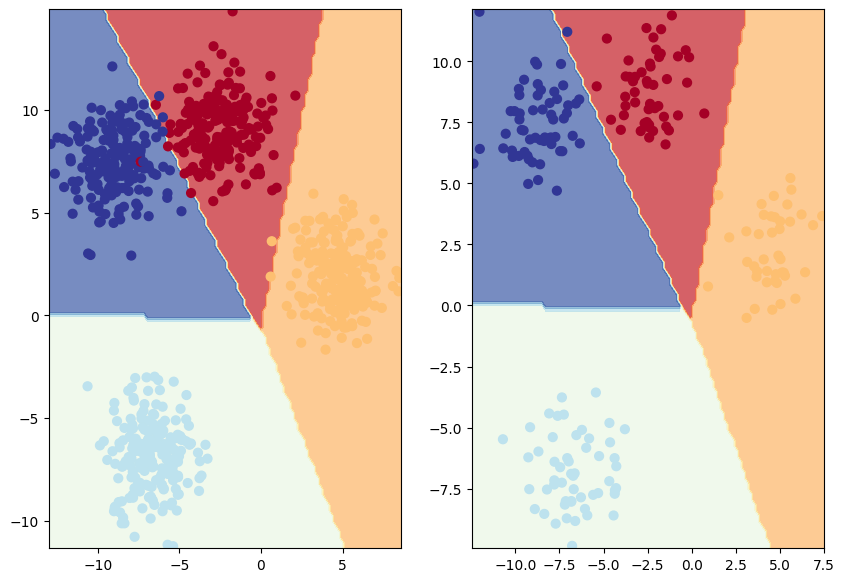

In [ ]:
import matplotlib.pyplot as plt
from helper_functions import plot_decision_boundary

plt.figure(figsize=(10, 7))

plt.subplot(1, 2, 1)
plot_decision_boundary(model_4, X_train_blob, y_train_blob)

plt.subplot(1, 2, 2)
plot_decision_boundary(model_4, X_test_blob, y_test_blob)

## 9. A few more classification metrics... (to evaluate our model)

* Accuracy - out of 100 samples , how many our model gets right?
* precision
* recall
* F1score
* confusion matrix
* Classification report

For more on classification metrics - https://towardsdatascience.com/beyond-accuracy-other-classification-metrics-you-should-know-in-machine-learning-ea671be83bb7/


| **Metric name/Evaluation method** | **Defintion** | **Code** |
| --- | --- | --- |
| Accuracy | Out of 100 predictions, how many does your model get correct? E.g. 95% accuracy means it gets 95/100 predictions correct. | [`torchmetrics.Accuracy()`](https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html#id3) or [`sklearn.metrics.accuracy_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) |
| Precision | Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0). | [`torchmetrics.Precision()`](https://torchmetrics.readthedocs.io/en/stable/classification/precision.html#id4) or [`sklearn.metrics.precision_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html) |
| Recall | Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives. | [`torchmetrics.Recall()`](https://torchmetrics.readthedocs.io/en/stable/classification/recall.html#id5) or [`sklearn.metrics.recall_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html) |
| F1-score | Combines precision and recall into one metric. 1 is best, 0 is worst. | [`torchmetrics.F1Score()`](https://torchmetrics.readthedocs.io/en/stable/classification/f1_score.html#f1score) or [`sklearn.metrics.f1_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) |
| [Confusion matrix](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/)  | Compares the predicted values with the true values in a tabular way, if 100% correct, all values in the matrix will be top left to bottom right (diagnol line). | [`torchmetrics.ConfusionMatrix`](https://torchmetrics.readthedocs.io/en/stable/classification/confusion_matrix.html#confusionmatrix) or [`sklearn.metrics.plot_confusion_matrix()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay.from_predictions) |
| Classification report | Collection of some of the main classification metrics such as precision, recall and f1-score. | [`sklearn.metrics.classification_report()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) |

Scikit-Learn (a popular and world-class machine learning library) has many implementations of the above metrics and you're looking for a PyTorch-like version, check out [TorchMetrics](https://torchmetrics.readthedocs.io/en/latest/), especially the [TorchMetrics classification section](https://torchmetrics.readthedocs.io/en/stable/pages/classification.html).




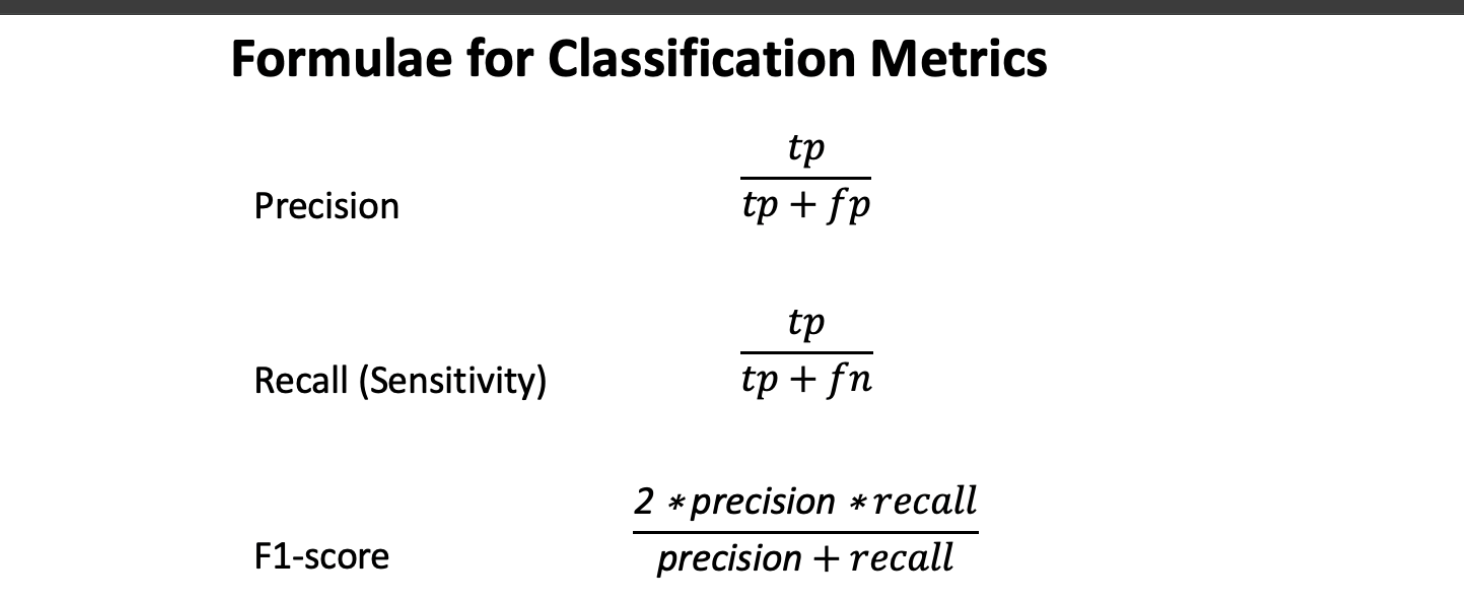

In [ ]:
!pip install torchmetrics

In [ ]:
from torchmetrics import Accuracy

# setup metric
accuracy_metric = Accuracy(task="multiclass", num_classes=5).to(device)

# calculate accuracy
accuracy_metric(y_preds, y_test_blob)

tensor(0.9950)

## Exercises

* exercises for this course - https://github.com/Faizan-Rashid/deep-learning-pytorch/blob/main/extras/exercises/02_pytorch_classification_exercises.ipynb

* solution of exercises - https://github.com/Faizan-Rashid/deep-learning-pytorch/blob/main/extras/solutions/02_pytorch_classification_exercises_solutions.ipynb
